In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
#from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier

#import pickle

In [2]:
colNames = list(range(1024))
colNames.append("label")
df = pd.read_csv('../qsar_oral_toxicity.csv', sep=';',names=colNames)

In [3]:
df

0  1  2  3  4  5  6  7  8  9  ...  1015  1016  1017  1018  1019  1020  \
0     0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
1     0  0  1  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
2     0  0  0  0  0  0  0  0  0  0  ...     0     0     1     0     0     0   
3     0  0  0  0  0  0  0  1  0  0  ...     0     0     0     0     0     0   
4     0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
...  .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
8987  0  0  0  0  0  0  0  1  0  0  ...     0     0     0     1     0     0   
8988  0  1  0  0  0  1  0  1  0  0  ...     0     0     0     1     0     0   
8989  0  0  0  0  0  0  0  1  0  0  ...     0     0     0     0     0     0   
8990  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
8991  0  0  1  0  0  0  0  0  0  0  ...     1     0     0     0     0     0   

      1021  1022  1023     label  
0        0     0     0  negative  
1        0     0     0  negative  
2        0     0     0  negative  
3        0     0     0  negative  
4        0     0     0  negative  
...    ...   ...   ...       ...  
8987     0     0     0  negative  
8988     0     0     0  negative  
8989     0     1     0  negative  
8990     0     0     0  negative  
8991     0     0     0  negative  

[8992 rows x 1025 columns]

In [4]:
#label 1 is positive; otherwise negative
df = pd.get_dummies(df)
df.drop("label_negative",1,inplace=True)
df = df.rename({"label_positive":"label"},axis=1)

In [5]:
df[df["label"]==1].shape
#according to paper's table, this means we have VT data, with ECFP_1024_02 or ECFP_1024_02R

(741, 1025)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8992 entries, 0 to 8991
Columns: 1025 entries, 0 to label
dtypes: int64(1024), uint8(1)
memory usage: 70.3 MB


In [7]:
df["label"].value_counts()

0    8251
1     741
Name: label, dtype: int64

In [8]:
#train, test split
train, test=train_test_split(df, test_size=0.3, random_state=1)
train.reset_index(drop=True, inplace=True)

In [9]:
#######<--

In [10]:
#######-->

In [11]:
train["label"].value_counts()

0    5765
1     529
Name: label, dtype: int64

In [12]:
#!pip install imblearn

In [13]:
###<--

In [14]:
#upsampling: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#t10
#from imblearn.over_sampling import SMOTE

#smote = SMOTE(random_state=12, sampling_strategy=1)#'minority')
#X_train, y_train = smote.fit_resample(train.drop(["label"],1), train["label"])

#plot_2d_space(X_train, y_train, 'SMOTE over-sampling')
#X_test=test.drop(["label"],1)
#y_test=test["label"]

In [15]:
###-->

In [16]:
#y_train.value_counts()

In [17]:
X_train=train.drop(["label"],1)
y_train=train["label"]

# Optimizing

In [18]:
#https://stackoverflow.com/questions/58815016/cross-validating-with-imblearn-pipeline-and-gridsearchcv

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

def imb_pipeline(clf, X, y, params):

    model = Pipeline([
        ('sampling', SMOTE(random_state=1, sampling_strategy=1)),
        ('classification', clf)
    ])
    #optimizing balanced_accuracy instead of accuracy score bc wee upsampled and have a balanced training set; can check accuracy score later, make suree it is low
    score={'BALANCED_ACCURACY':'balanced_accuracy', 'RECALL':'recall', 'F1':'f1'}

    gcv = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=score, n_jobs=12, refit='AUC')
    gcv.fit(X, y)

    return gcv

def print_scores(grid_result):
    print("Best BALANCED_ACCURACY: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_BALANCED_ACCURACY']
    stds = grid_result.cv_results_['std_test_BALANCED_ACCURACY']
    means2 = grid_result.cv_results_['mean_test_RECALL']
    stds2 = grid_result.cv_results_['std_test_RECALL']
    means3 = grid_result.cv_results_['mean_test_F1']
    stds3 = grid_result.cv_results_['std_test_F1']
    params = grid_result.cv_results_['params']
    print("BALANCED_ACCURACY, RECALL, F1 with PARAMS")
    for mean, std, mean2, std2, mean3, std3, param in zip(means, stds, means2, stds2, means3, stds3, params):
        print("%f (%f), %f (%f), %f (%f) with: %r" % (mean, std, mean2, std2, mean3, std3, param))

In [19]:
from scipy.stats import loguniform

classifiers = LogisticRegression(C=1.0, penalty='l2',
                     random_state=None, tol=0.0001, verbose=0,
                     warm_start=False)

#see solver in https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
params = [{'classification__penalty':['elasticnet'],
          'classification__solver':['saga'],
          'classification__C': loguniform(1e-5, 100)},
          {'classification__penalty':['none','l2'],
          'classification__solver':['newton-cg', 'lbfgs', 'sag','saga'],
          'classification__C': loguniform(1e-5, 100)},
          {'classification__penalty':['l1'],
          'classification__solver':('liblinear','saga'),
          'classification__C': loguniform(1e-5, 100)}
         ]

        
    
#for param, classifier in zip(params, classifiers):
grid_result = imb_pipeline(classifiers, X_train, y_train, params) 

#print
print_scores(grid_result)

Best AUC: 0.828202 using {'classification__C': 0.1}
AUC, RECALL, PRECISION with PARAMS
0.810211 (0.025646), 0.572650 (0.042133), 0.344704 (0.031989) with: {'classification__C': 0.01}
0.828202 (0.023182), 0.525355 (0.048645), 0.402873 (0.045083) with: {'classification__C': 0.1}
0.822192 (0.023967), 0.521581 (0.049722), 0.389926 (0.045080) with: {'classification__C': 1.0}
0.805173 (0.022899), 0.506541 (0.024989), 0.362203 (0.037521) with: {'classification__C': 10}


In [20]:
from scipy.stats import randint

classifiers = RandomForestClassifier(n_estimators=50)

#some selected params in https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
params = {'classification__n_estimators': randint(10, 1000), 'classification__max_depth': randint(10,100),
         'classification__criterion':('gini', 'entropy'), 'classification__max_features':('auto', 'sqrt', 'log2')}
    
#for param, classifier in zip(params, classifiers):
grid_result = imb_pipeline(classifiers, X_train, y_train, params) 

#print
print_scores(grid_result)

Best AUC: 0.891250 using {'classification__max_depth': 70, 'classification__n_estimators': 500}
AUC, RECALL, PRECISION with PARAMS
0.884374 (0.018674), 0.549937 (0.042272), 0.525365 (0.040136) with: {'classification__max_depth': 30, 'classification__n_estimators': 100}
0.884860 (0.017919), 0.540503 (0.038046), 0.525635 (0.039765) with: {'classification__max_depth': 30, 'classification__n_estimators': 300}
0.885272 (0.019077), 0.546181 (0.039925), 0.532990 (0.044363) with: {'classification__max_depth': 30, 'classification__n_estimators': 500}
0.885276 (0.018924), 0.496981 (0.048628), 0.571775 (0.045356) with: {'classification__max_depth': 50, 'classification__n_estimators': 100}
0.887726 (0.017712), 0.515921 (0.040865), 0.591633 (0.034520) with: {'classification__max_depth': 50, 'classification__n_estimators': 300}
0.889533 (0.015074), 0.523468 (0.044473), 0.595462 (0.026525) with: {'classification__max_depth': 50, 'classification__n_estimators': 500}
0.883086 (0.018083), 0.508320 (0.05

In [21]:
import numpy
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import uniform
from scipy.stats import randint
from scipy.stats import loguniform

#setting up NN model 
def setUpModel(n1, n2, lr=0.001, momentums=0.9):
    #set up and compile a model
    model = keras.Sequential()
    
    model.add(layers.Dense(n1, input_dim=X_train.shape[1], activation="sigmoid"))
    model.add(layers.Dense(n2, activation="sigmoid"))
    model.add(layers.Dense(1, activation="sigmoid")) #1 output layer bc of binary output
    
    model.compile(loss='mse',
         optimizer = keras.optimizers.SGD(momentum=momentums, learning_rate=lr),
         metrics=['accuracy',
             keras.metrics.Recall(name="recall", thresholds=0.3)
                 ])
        
    return model

#create a scikilearn-compatible model
Kmodel = KerasClassifier(build_fn=setUpModel, verbose=0, batch_size=100, epochs=100)
# define the grid search parameters
neurons1 = (5, 10, 15, 20)
neurons2 = (5, 10, 15, 20)
lr = [0.005,0.01,0.05,0.1]
momentum = [0.1, 0.4,0.7,0.9,0.99]
params = {"classification__n1":randint(5,15), "classification__n2":randint(5,15),
         "classification__lr":loguniform(0.0001,10), "classification__momentums": uniform(0.01,0.999999)}

#for param, classifier in zip(params, classifiers):
grid_result = imb_pipeline(Kmodel, X_train, y_train, params) 

#print
print_scores(grid_result)

Using TensorFlow backend.


Best AUC: 0.751617 using {'classification__n1': 3, 'classification__n2': 3}
AUC, RECALL, PRECISION with PARAMS
0.728944 (0.044374), 0.697217 (0.167380), 0.186264 (0.056960) with: {'classification__n1': 2, 'classification__n2': 2}
0.742906 (0.015757), 0.656411 (0.137872), 0.207137 (0.057048) with: {'classification__n1': 2, 'classification__n2': 3}
0.742653 (0.027647), 0.481739 (0.307786), 0.205072 (0.158900) with: {'classification__n1': 3, 'classification__n2': 2}
0.751617 (0.037186), 0.570058 (0.113862), 0.297035 (0.047895) with: {'classification__n1': 3, 'classification__n2': 3}


# Get optimized models' scores

In [22]:
# evaluate the model using a given test condition
#def evaluate_model(cv, model):
#    #pipeline
#    steps=[('scaler',MinMaxScaler()),('model', model)]
#    pipeline = Pipeline(steps=steps)
#    # evaluate the model
#    scores = cross_validate(pipeline, X, y, scoring=['accuracy','precision', 'recall'], cv=cv, n_jobs=-1)
    # return scores
#    return [mean(scores['test_accuracy']),mean(scores['test_precision']),mean(scores['test_recall'])]

# Result (using best parameters)

## Precision, Recall vs Threshold

In [23]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

train["label"].value_counts()

0    5765
1     529
Name: label, dtype: int64

In [31]:
#log
X_test = test.drop(["label"],1)
y_test = test["label"]

log = LogisticRegression(C=0.1, max_iter=2000)

log.fit(X_train, y_train)

#plot_precision_recall_curve(log, X_test, y_test)

LogisticRegression(C=0.1, max_iter=2000)

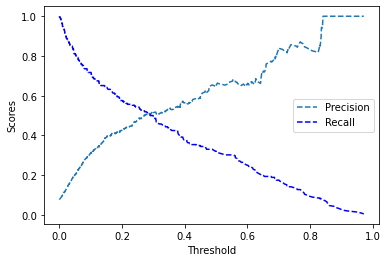

In [32]:
y_scores=log.predict_proba(X_test)
prec, rec, tre = precision_recall_curve(y_test, y_scores[:,1])
plt.plot(tre, prec[:-1], linestyle='--', label='Precision')
plt.plot(tre, rec[:-1], linestyle='--', color = 'b', label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Scores")
plt.legend()
plt.show()

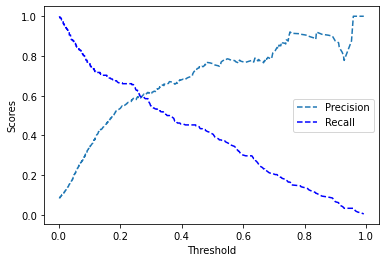

In [26]:
#forest; grid search 2 vars
classifier = RandomForestClassifier(n_estimators=500, max_depth=70)
classifier.fit(X_train, y_train)
#plot_precision_recall_curve(classifier, X_test, y_test)
y_scores=classifier.predict_proba(X_test)
prec, rec, tre = precision_recall_curve(y_test, y_scores[:,1])
plt.plot(tre, prec[:-1], linestyle='--', label='Precision')
plt.plot(tre, rec[:-1], linestyle='--', color = 'b', label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Scores")
plt.legend()
plt.show()

In [27]:
def setUpModel(n1=5, n2=5):
    #set up and compile a model
    model = keras.Sequential()
    
    model.add(layers.Dense(n1, input_dim=X_train.shape[1], activation="sigmoid"))
    model.add(layers.Dense(n2, activation="sigmoid"))
    model.add(layers.Dense(1, activation="sigmoid")) #1 output layer bc of binary output
    
    model.compile(loss='mse',
         optimizer = keras.optimizers.SGD(momentum=0.99, learning_rate=0.01),
         metrics=['accuracy',
             keras.metrics.Recall(name="recall", thresholds=0.3)
                 ])
        
    return model

#create a scikilearn-compatible model
Kmodel = KerasClassifier(build_fn=setUpModel, verbose=0, batch_size=1000, epochs=30)
Kmodel.fit(X_train, y_train)
#plot_precision_recall_curve(Kmodel, X_test, y_test)

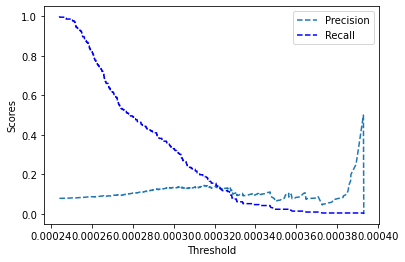

In [28]:
y_scores=Kmodel.predict_proba(X_test)
prec, rec, tre = precision_recall_curve(y_test, y_scores[:,1])
plt.plot(tre, prec[:-1], linestyle='--', label='Precision')
plt.plot(tre, rec[:-1], linestyle='--', color = 'b', label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Scores")
plt.legend()
plt.show()

In [29]:
prec

array([0.07901603, 0.07870198, 0.07873134, ..., 0.5       , 0.        ,
       1.        ])

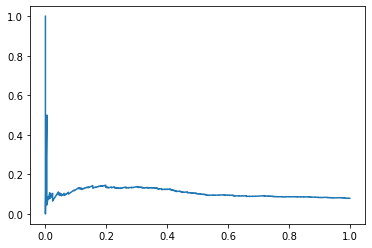

In [30]:
plt.plot(rec,prec )

## ROC